
<div style="line-height:2px;border: solid orange">
    <p>
    <p style="color:blue;font-family:arial;text-align:right;font-size:20"> Visión por Computador &nbsp;&nbsp;
    <p style="color:blue;font-family:arial;text-align:right;font-size:16"> Master en Ciencias de Datos e Ingeniería de Ordenadores   &nbsp;&nbsp;
  <p style="color:blue;font-family:arial;text-align:right;font-size:16"> Rosa Mª. Rodríguez Sánchez   &nbsp;&nbsp;
    <p style="color:blue;font-family:arial;text-align:right;font-size:10"> Dpto. Ciencias de la Computación e Inteligencia Artificial. &nbsp;&nbsp;  
    <p style="color:blue;font-family:arial;text-align:right;font-size:10"> ETSIIT. Universidad de Granada   &nbsp;&nbsp;
        <p>
</div>

#Transferencia de Conocimiento. Clasificación de imágenes

## Introducción
En esta lección veremos dentro de la clasificación usando aprendizaje profundo como aplicar la **transferencia de conocimiento**. Vamos a entender por transferencia de conocimiento a el proceso de tomar rasgos aprendidos sobre un problema para usarlo en un nuevo problema de características similares.
La transferencia de conocimiento se usa cuando tenemos una base de datos con muy pocos casos para entrenar un modelo completo.
La pasos para  aplicar transferencia de conocimiento podrían ser los siguientes:
* Tomamos capas de un modelo previamente entrenado en otro problema.
* Congerlar las capas, esto quiere decir que no se destruye ninguna información aprendida en estas capas cuando apliquemos el entrenamiento.
* Añadir algunas capas a nuestro modelo relativas  a la parte de clasificación, las capas finales, que se situan detrás de las congeladas. Además de las primeras capas que permite adaptar los datos a la red.
* Entrenar el conjunto de nuevas capas con nuestro conjunto de datos.

Un último paso opcional es lo que se denomina **fine-tuning**. Esto consiste en descongelar el modelo entero, y reentrenar el modelo entero con el nuevo conjunto de datos con una razón de aprendizaje muy baja. Se parte con los rasgos aprendidos por el modelo original.
Vamos a ver todos estos conceptos usando un modelo preentrenado sobre el conjunto de imágenes <a src=http://www.image-net.org/>ImageNet</a> y lo renetrenamos con la base de datos de <a src=https://www.kaggle.com/c/dogs-vs-cats> Kaggle "dogs and cats"</a>.


### Bibliotecas que necesitamos


In [1]:
#!pip install tensorflow


import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
import numpy as np

2025-03-09 17:09:51.042579: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1741536591.056380   42147 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1741536591.060779   42147 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-09 17:09:51.075705: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Congelación de capas
Las capas y modelos tienen tres atributos relativos al peso:
* weights: es la lista de los variables asociadas a los pesos de la capa.
* trainable_weights: es la lista de aquellos pesos que son modificados, via gradiente descendente, para minimizar el error durante el entrenamiento.
* non_trainable_weights: es la lista de aquellos pesos que no son entrenados. Son mosificados por el modelo durante la fase de ir hacia adelante.

Por ejemplo una capa densa tiene 2 pesos entrenables (kernel y sesgo).


In [2]:
layer = tf.keras.layers.Dense(3)
layer.build((None, 4))  # Crea los pesos

print("weights:", len(layer.weights))
print("weights:", layer.weights)
print("trainable_weights:", len(layer.trainable_weights))
print("non_trainable_weights:", len(layer.non_trainable_weights))


I0000 00:00:1741536592.765660   42147 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1398 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2050, pci bus id: 0000:01:00.0, compute capability: 8.6


weights: 2
weights: [<Variable path=dense/kernel, shape=(4, 3), dtype=float32, value=[[-0.5684717  -0.38588315 -0.48752198]
 [ 0.7708571  -0.32127535 -0.86644214]
 [-0.09277284 -0.7700393  -0.7079774 ]
 [ 0.00691026 -0.10681057  0.30862653]]>, <Variable path=dense/bias, shape=(3,), dtype=float32, value=[0. 0. 0.]>]
trainable_weights: 2
non_trainable_weights: 0


En general, todos los pesos son pesos entrenables. La única capa que no tiene pesos entrenables es la capa BatchNormalization. Usa pesos no entrenables para mantener la traza de la media y la varianza de sus entradas durante el entrenamiento. Pero tambien tiene dos pesos entrenables que son parte de la formualación lineal.


In [3]:
#en una capa BatchNormalization tenemos como parámetros
# media varianza beta y gamma. Esto dos últimos son entrenables
#la media y varianza no son enrenables.
layer = tf.keras.layers.BatchNormalization()
layer.build((None, 4))  # Crea los pesos

print("weights:", len(layer.weights))
print("trainable_weights:", len(layer.trainable_weights))
print("non_trainable_weights:", len(layer.non_trainable_weights))


weights: 4
trainable_weights: 2
non_trainable_weights: 2


Las capas y modelos tienen una variable booleana entrenable. Su valor puede ser modificado. Por ejemplo poniendo layer.trainable a False los pesos de la capa pasan de ser entrenables a no entrenables.  Este proceso se denomina **congelar la capa**. En este estado la capa durante el entrenamiento no será modificada.



In [4]:
layer = tf.keras.layers.Dense(3)
layer.build((None, 4))  # Creamos los pesos
layer.trainable = False  # Congelamos la capa

print("weights:", len(layer.weights))
print("trainable_weights:", len(layer.trainable_weights))
print("non_trainable_weights:", len(layer.non_trainable_weights))


weights: 2
trainable_weights: 0
non_trainable_weights: 2


Veamos un ejemplo

In [5]:
# Creamos una arquitectura con dos capas
layer1 = tf.keras.layers.Dense(3, activation="relu",input_shape=(3,))
layer2 = tf.keras.layers.Dense(3, activation="sigmoid")
model = tf.keras.Sequential([ layer1, layer2])

# Congelamos la primera capa
layer1.trainable = False

# Hacemos una copia de los pesos para comprobar si se ha modificado
initial_layer1_weights_values = layer1.get_weights()

# Entrenamos el modelo
model.compile(optimizer="adam", loss="mse")
model.fit(np.random.random((2, 3)), np.random.random((2, 3)))

# Comprobamos que los pesos de la primera capa no se han modificado
final_layer1_weights_values = layer1.get_weights()
# Salta un excepción si los dos objetos nos son iguales
np.testing.assert_allclose(
    initial_layer1_weights_values[0], final_layer1_weights_values[0]
)
np.testing.assert_allclose(
    initial_layer1_weights_values[1], final_layer1_weights_values[1]
)


/home/migue8gl/Master/vision_por_computador/cnn/.venv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 436ms/step - loss: 0.0527


I0000 00:00:1741536593.669814   42293 service.cc:148] XLA service 0x7d83200060f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1741536593.669841   42293 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 2050, Compute Capability 8.6
2025-03-09 17:09:53.679499: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1741536593.717945   42293 cuda_dnn.cc:529] Loaded cuDNN version 90501
I0000 00:00:1741536593.837275   42293 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


### Atributo trainable.
En el siguiente ejemplo se muestra que capas son entrenables o no. Cuando se pone un modelo o capa a no entrenable todas las subcapas se vuelven no entrenables.


In [ ]:
inner_model = tf.keras.Sequential(
    [
        tf.keras.layers.InputLayer(input_shape=(3,)),
        tf.keras.layers.Dense(3, activation="relu"),
        tf.keras.layers.Dense(3, activation="relu"),
    ]
)

model = tf.keras.Sequential(
    [
        tf.keras.layers.InputLayer(input_shape=(3,)),
        inner_model,
        tf.keras.layers.Dense(3, activation="sigmoid"),
    ]
)

model.trainable = False  # Congelamos
model.summary()


/home/migue8gl/Master/vision_por_computador/cnn/.venv/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_1 (Sequential)       │ (None, 3)              │            24 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 3)              │            12 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 36 (144.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 36 (144.00 B)

## Ejemplo Transferencia de Conocimiento

A modo de ejemplo vamos a aplicar una CNN usando transferencia de conocimiento a la base de datos Kaggle cats and dogs.
Vamos a usar la arquitectura Xception previamente entrenada sobre ImageNet.

En primer lugar vamos a cargar nuestra base de datos.

In [7]:
import tensorflow_datasets as tfds
#tfds.disable_progress_bar()
#No usamos toda la base de datos solamente el 60%
(train_ds, validation_ds, test_ds),metadata = tfds.load(
    "cats_vs_dogs",
    #  10% para validación 10% para test
    split=["train[:40%]", "train[40%:50%]", "train[50%:60%]"],
    with_info=True,
    as_supervised=True  # cargamos las etiquetas
)

print("Imágenes para el entrenamiento: %d" % tf.data.experimental.cardinality(train_ds))
print("Imágenes para la validación: %d" % tf.data.experimental.cardinality(validation_ds))
print("Imagenes para el test: %d" % tf.data.experimental.cardinality(test_ds))
num_classes = metadata.features['label'].num_classes
print(num_classes)


2025-03-09 17:09:54.291338: W external/local_tsl/tsl/platform/cloud/google_auth_provider.cc:184] All attempts to get a Google authentication bearer token failed, returning an empty token. Retrieving token from files failed with "NOT_FOUND: Could not locate the credentials file.". Retrieving token from GCE failed with "FAILED_PRECONDITION: Error executing an HTTP request: libcurl code 6 meaning 'Couldn't resolve host name', error details: Could not resolve host: metadata.google.internal".


/home/migue8gl/Master/vision_por_computador/cnn/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0x

Dataset cats_vs_dogs downloaded and prepared to /home/migue8gl/tensorflow_datasets/cats_vs_dogs/4.0.1. Subsequent calls will reuse this data.
Imágenes para el entrenamiento: 9305
Imágenes para la validación: 2326
Imagenes para el test: 2326
2


In [8]:
print(tfds.__version__)

4.9.7


Veamos algunas de las imágenes

2025-03-09 17:11:56.510544: I tensorflow/core/kernels/data/tf_record_dataset_op.cc:376] The default buffer size is 262144, which is overridden by the user specified `buffer_size` of 8388608
2025-03-09 17:11:56.585817: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


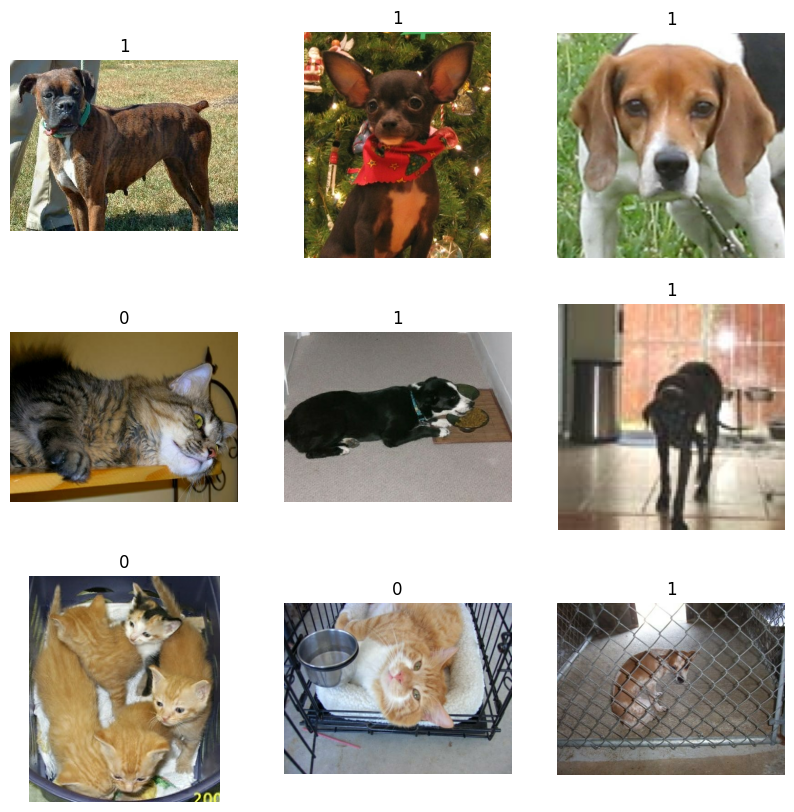

In [9]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
for i, (image, label) in enumerate(train_ds.take(9)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image)
    plt.title(int(label))
    plt.axis("off")
#Label=1 dot label=0 cat

#### Homogenizar las imágenes
Las imágenes tienen diferentes tamaños. Las imágenes son de color, 3 canales RGB, en el rango cada uno de ellos 0-255. Antes de pasarlas a nuestra CNN debemos realizar los siguientes pasos:
* Igualar el tamaño de todas las imágenes a 150x150.
* Usar aumentación del conjunto de datos de forma aleatoria
* Normalizamos los valores de los pixeles al rango -1,1

En el siguiente código realizamos los dos primeros pasos:


In [10]:
size = (150, 150)

train_ds = train_ds.map(lambda x, y: (tf.image.resize(x, size), y))
validation_ds = validation_ds.map(lambda x, y: (tf.image.resize(x, size), y))
test_ds = test_ds.map(lambda x, y: (tf.image.resize(x, size), y))



batch_size = 32
#la primera vez que se itera sobre la base de datos se pone en cache.
#en las siguientes iteraciones se tomarán los datos de la cache.
#creamos lotes de tamaño batch_size
#prefetch permite preparar los siguientes elementos mientras
#que estan siendo procesaods los actuales elementos.
train_ds = train_ds.cache().batch(batch_size).prefetch(buffer_size=10)
validation_ds = validation_ds.cache().batch(batch_size).prefetch(buffer_size=10)
test_ds = test_ds.cache().batch(batch_size).prefetch(buffer_size=10)
print(train_ds)


<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>


A continuación vamos a aplicar a las imágenes diferentes  transformaciones geométricas. Este proceso evita el sobre ajuste de la red. Para ello creamos una arquitectura con dos capas una que realiza reflejo horizontal y otra rotación.

In [11]:
from tensorflow import keras
from keras import layers

data_augmentation = keras.Sequential(
    [
        #Reflejo horizontal
        layers.RandomFlip("horizontal"),
        #Rotaciones
        layers.RandomRotation(0.1),
    ]
)
#otras transformaciones posibles puede ser
#RandomCrop layer
#RandomTranslation layer
#RandomZoom layer
#RandomContrast layer
#RandomBrightness layer



Veamos un ejemplo de aplicación de data_augmentation


(32, 150, 150, 3)


2025-03-09 17:11:57.170888: W tensorflow/core/kernels/data/cache_dataset_ops.cc:914] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2025-03-09 17:11:57.783188: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


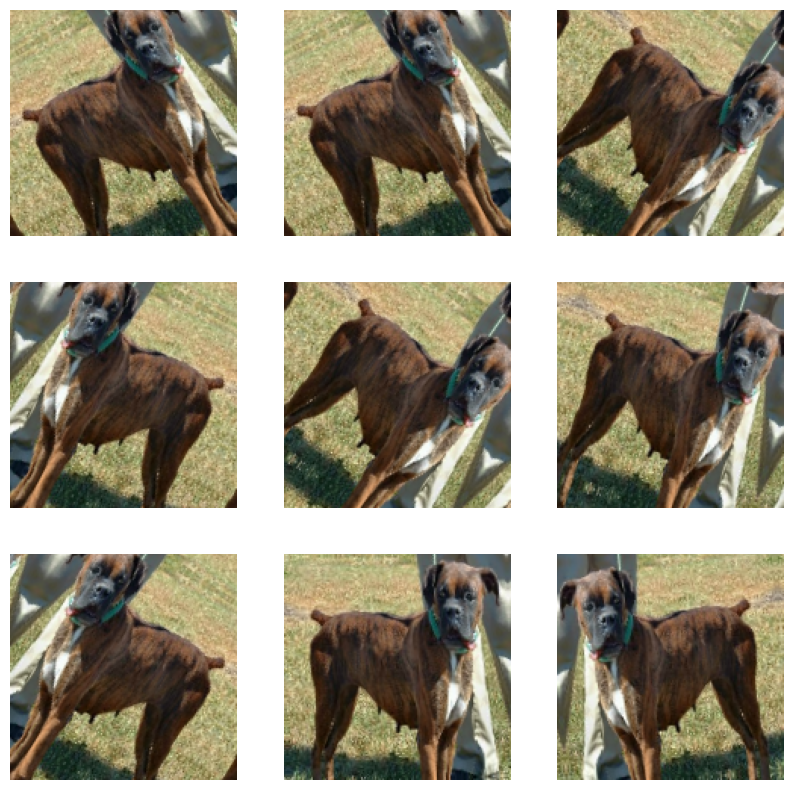

In [12]:
import numpy as np

for images, labels in train_ds.take(1):
    plt.figure(figsize=(10, 10))
    print(images.shape)
    first_image = images[0]

    #plt.imshow(first_image)

    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        #expand_dims lo que hace es poner como primera dimension el tamaño de lote que es 1 luego 150x150x3
        augmented_image = data_augmentation(tf.expand_dims(first_image, axis=0), training=True)

        plt.imshow(augmented_image[0].numpy().astype("int32"))

        plt.axis("off")



Antes de definir el modelo vamos a aclarar que hace la capa GlobalMaxPooling2d. Esta capa obtiene el maximo de todos las entradas en la capa.

In [13]:
#EJEMPLO de GlobalMaxPooling
# creamos el modelo
model = tf.keras.Sequential()
model.add(tf.keras.layers.Conv2D(1, (3,3), activation='relu',padding="same", input_shape=(8, 8, 1)))
model.add(tf.keras.layers.GlobalMaxPooling2D())
model.summary()

/home/migue8gl/Master/vision_por_computador/cnn/.venv/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 8, 8, 1)        │            10 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling2d            │ (None, 1)              │             0 │
│ (GlobalMaxPooling2D)            │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10 (40.00 B)

 Trainable params: 10 (40.00 B)

 Non-trainable params: 0 (0.00 B)

### Definimos el modelo

Las características son:
* Vamos a usar Xception como arquitectura base
* Vamos a añadir una capa de normalización para escalar la imagen que están en el rango [0,255] al rango [-1,1]
* Vamos a insertar una capa Dropout antes para la capa de clasificación para evitar sobre ajuste.
* Nos aseguramos poner training=false cuando usamos el modelo base. Asi que el aprendizaje afectara a la parte de clasificación y primera capas


En el código de abajo hay tener en cuenta que GlobalAveragePooling2D submuestrea el conjunto de rasgos en un solo rasgo.

In [19]:
#Los modelos que contiene keras los puedes consultar en https://keras.io/api/applications/
base_model = keras.applications.Xception(
    weights="imagenet",  # Cargamos los pesos entrenados con ImageNet.
    input_shape=(150, 150, 3), #por defecto acepta 299x299x3
    include_top=False,#La primera capa  no se incluye
)
#si quieres ver Xception
#base_model.summary()

# Congelamos
base_model.trainable = False

# Añadirmos la primera capa
inputs = keras.Input(shape=(150, 150, 3))
x = data_augmentation(inputs)  # Aplicamos el aumento de datos.
#Normalizamos al rango [-1,1]
#usando outputs = (inputs - mean) / sqrt(var)
mean = np.array([127.5] * 3)
var = mean ** 2

# Scale inputs to [-1, +1]
norm_layer = keras.layers.Normalization(mean=mean,variance=var)

x = norm_layer(x)



x = base_model(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)  # Regularizamos
outputs = keras.layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

model.summary()


Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)      │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_3 (Sequential)       │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ normalization_1 (Normalization) │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ xception (Functional)           │ (None, 5, 5, 2048)     │    20,861,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │         2,049 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,863,529 (79.59 MB)

 Trainable params: 2,049 (8.00 KB)

 Non-trainable params: 20,861,480 (79.58 MB)

### Entrenamos la primera capa


In [ ]:
model.compile(
    optimizer=keras.optimizers.Adam(),
    #cuando solamente tenemos dos etiquetas. COn from_logits=true para obtener
    #probabilidades
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    #redondea las probabilidades a 0-1 y estima como coincide y_pred y y_real
    metrics=[keras.metrics.BinaryAccuracy()],
)
#Deberiamos usar más epocas pero por rapidez ponemos 5
epochs = 5
model.fit(train_ds, epochs=epochs, validation_data=validation_ds)


Epoch 1/5


Ahora evaluamos el modelo sobre el conjunto test. Pero previamente lo vamos a almacenar en disco para poder recuperarlo en el futuro y no tener que entrenarlo de nuevo.

73/73 ━━━━━━━━━━━━━━━━━━━━ 8s 104ms/step - binary_accuracy: 0.9785 - loss: 0.0635
Test loss: 0.07669883966445923
Test accuracy: 0.9724849462509155
73/73 ━━━━━━━━━━━━━━━━━━━━ 8s 107ms/step
Clase predicha [0]


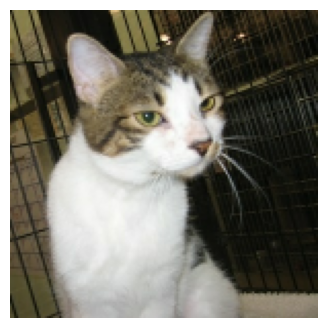

In [ ]:
#almacenamos
#model.save('mimodelo_xception.h5')
#como se recuperaria
#model = keras.models.load_model('mimodelo_xception.h5')

#Ahora lo vamos a evaluar
score = model.evaluate(test_ds)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

#predecir las etiquetas

y_prob = model.predict(test_ds)
y_classes = (y_prob > 0.5)*1

print('Clase predicha',y_classes[0])
for images, label in test_ds.take(1):
    plt.figure(figsize=(4, 4))
    first_image = images[0]
    plt.imshow(first_image.numpy().astype("int32"))
    plt.axis("off")




## Fine-Tuning
Podemos ahora descongelar todo el modelo y reentrenar el modelo entero con una razón de aprendizaje muy baja.
Este paso puede obtener mejoras en la agudeza, pero tenemos que tener en mente que tambien podriamos obtener un sobreajuste. Así que hay que mirar todo con cuidado.
Este paso se debe hacer tras haber entrenado el modelo con las capas congeladas para alcanzar la convergencia de las capas no congeladas. Si mezclaramos el entrenamiento con capas ya entrenadas y capas que se inicializan aleatoriamente puede  causar que el gradiente debe acometer grandes pasos durante el entrenamiento destruyendo los rasgos de las capas ya entrenadas.
En esta etapa también es crítico usar razones de aprendizaje muy pequeñas ya que el conjunto de datos sobre los que se están aplicando es menor que sobre el conjunto de datos para el que fue entrenado el modelo base. Además si se aplica grandes modificaciones de los pesos, que se obtiene a una razón de aprendizaje mayor, se puede obtener sobre ajuste. Por lo tanto nuestro objetivo es readaptar un poco los pesos a la nueva base de datos.
Así se implementa fine-tuning al modelo entero.



In [ ]:
# Descongelamos el modelo base
base_model.trainable = True

model.compile(optimizer=keras.optimizers.Adam(1e-5),  # Una razón de aprendizaje muy pequeña
              loss=keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=[keras.metrics.BinaryAccuracy()])

# Entrenamos el modelo entero
model.fit(train_ds, epochs=5,  validation_data=validation_ds)

#almacenamos
#model.save('mimodelo_xception_entero.h5')
#como se recuperaria
#model = keras.models.load_model('mimodelo_xception_entero.h5')

#Ahora lo vamos a evaluar
score = model.evaluate(test_ds)

print('Test loss:', score[0])
print('Test accuracy:', score[1])


Epoch 1/5


2025-03-09 17:17:02.907207: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:497] Allocator (GPU_0_bfc) ran out of memory trying to allocate 7.20MiB (rounded to 7547904)requested by op StatefulPartitionedCall/functional_6_1/xception_1/block7_sepconv1_1/separable_conv2d
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2025-03-09 17:17:02.907451: I external/local_xla/xla/tsl/framework/bfc_allocator.cc:1053] BFCAllocator dump for GPU_0_bfc
2025-03-09 17:17:02.907476: I external/local_xla/xla/tsl/framework/bfc_allocator.cc:1060] Bin (256): 	Total Chunks: 3529, Chunks in use: 3529. 882.2KiB allocated for chunks. 882.2KiB in use in bin. 18.1KiB client-requested in use in bin.
2025-03-09 17:17:02.907491: I external/local_xla/xla/tsl/framework/bfc_allocator.cc:1060] Bin (512): 	Total Chunks: 24, Chunks in use: 23. 12.2KiB allocated 

ResourceExhaustedError: Graph execution error:

Detected at node functional_6_1/xception_1/block7_sepconv1_1/separable_conv2d defined at (most recent call last):
  File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main

  File "/usr/lib/python3.10/runpy.py", line 86, in _run_code

  File "/home/migue8gl/Master/vision_por_computador/cnn/.venv/lib/python3.10/site-packages/ipykernel_launcher.py", line 18, in <module>

  File "/home/migue8gl/Master/vision_por_computador/cnn/.venv/lib/python3.10/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/migue8gl/Master/vision_por_computador/cnn/.venv/lib/python3.10/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/migue8gl/Master/vision_por_computador/cnn/.venv/lib/python3.10/site-packages/tornado/platform/asyncio.py", line 205, in start

  File "/usr/lib/python3.10/asyncio/base_events.py", line 603, in run_forever

  File "/usr/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once

  File "/usr/lib/python3.10/asyncio/events.py", line 80, in _run

  File "/home/migue8gl/Master/vision_por_computador/cnn/.venv/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 545, in dispatch_queue

  File "/home/migue8gl/Master/vision_por_computador/cnn/.venv/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 534, in process_one

  File "/home/migue8gl/Master/vision_por_computador/cnn/.venv/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 437, in dispatch_shell

  File "/home/migue8gl/Master/vision_por_computador/cnn/.venv/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 362, in execute_request

  File "/home/migue8gl/Master/vision_por_computador/cnn/.venv/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 778, in execute_request

  File "/home/migue8gl/Master/vision_por_computador/cnn/.venv/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 449, in do_execute

  File "/home/migue8gl/Master/vision_por_computador/cnn/.venv/lib/python3.10/site-packages/ipykernel/zmqshell.py", line 549, in run_cell

  File "/home/migue8gl/Master/vision_por_computador/cnn/.venv/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3077, in run_cell

  File "/home/migue8gl/Master/vision_por_computador/cnn/.venv/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3132, in _run_cell

  File "/home/migue8gl/Master/vision_por_computador/cnn/.venv/lib/python3.10/site-packages/IPython/core/async_helpers.py", line 128, in _pseudo_sync_runner

  File "/home/migue8gl/Master/vision_por_computador/cnn/.venv/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3336, in run_cell_async

  File "/home/migue8gl/Master/vision_por_computador/cnn/.venv/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3519, in run_ast_nodes

  File "/home/migue8gl/Master/vision_por_computador/cnn/.venv/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3579, in run_code

  File "/tmp/ipykernel_42147/2021817128.py", line 9, in <module>

  File "/home/migue8gl/Master/vision_por_computador/cnn/.venv/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/home/migue8gl/Master/vision_por_computador/cnn/.venv/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py", line 371, in fit

  File "/home/migue8gl/Master/vision_por_computador/cnn/.venv/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py", line 219, in function

  File "/home/migue8gl/Master/vision_por_computador/cnn/.venv/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py", line 132, in multi_step_on_iterator

  File "/home/migue8gl/Master/vision_por_computador/cnn/.venv/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py", line 113, in one_step_on_data

  File "/home/migue8gl/Master/vision_por_computador/cnn/.venv/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py", line 57, in train_step

  File "/home/migue8gl/Master/vision_por_computador/cnn/.venv/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/home/migue8gl/Master/vision_por_computador/cnn/.venv/lib/python3.10/site-packages/keras/src/layers/layer.py", line 909, in __call__

  File "/home/migue8gl/Master/vision_por_computador/cnn/.venv/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/home/migue8gl/Master/vision_por_computador/cnn/.venv/lib/python3.10/site-packages/keras/src/ops/operation.py", line 52, in __call__

  File "/home/migue8gl/Master/vision_por_computador/cnn/.venv/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 156, in error_handler

  File "/home/migue8gl/Master/vision_por_computador/cnn/.venv/lib/python3.10/site-packages/keras/src/models/functional.py", line 183, in call

  File "/home/migue8gl/Master/vision_por_computador/cnn/.venv/lib/python3.10/site-packages/keras/src/ops/function.py", line 171, in _run_through_graph

  File "/home/migue8gl/Master/vision_por_computador/cnn/.venv/lib/python3.10/site-packages/keras/src/models/functional.py", line 643, in call

  File "/home/migue8gl/Master/vision_por_computador/cnn/.venv/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/home/migue8gl/Master/vision_por_computador/cnn/.venv/lib/python3.10/site-packages/keras/src/layers/layer.py", line 909, in __call__

  File "/home/migue8gl/Master/vision_por_computador/cnn/.venv/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/home/migue8gl/Master/vision_por_computador/cnn/.venv/lib/python3.10/site-packages/keras/src/ops/operation.py", line 52, in __call__

  File "/home/migue8gl/Master/vision_por_computador/cnn/.venv/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 156, in error_handler

  File "/home/migue8gl/Master/vision_por_computador/cnn/.venv/lib/python3.10/site-packages/keras/src/models/functional.py", line 183, in call

  File "/home/migue8gl/Master/vision_por_computador/cnn/.venv/lib/python3.10/site-packages/keras/src/ops/function.py", line 171, in _run_through_graph

  File "/home/migue8gl/Master/vision_por_computador/cnn/.venv/lib/python3.10/site-packages/keras/src/models/functional.py", line 643, in call

  File "/home/migue8gl/Master/vision_por_computador/cnn/.venv/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/home/migue8gl/Master/vision_por_computador/cnn/.venv/lib/python3.10/site-packages/keras/src/layers/layer.py", line 909, in __call__

  File "/home/migue8gl/Master/vision_por_computador/cnn/.venv/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/home/migue8gl/Master/vision_por_computador/cnn/.venv/lib/python3.10/site-packages/keras/src/ops/operation.py", line 52, in __call__

  File "/home/migue8gl/Master/vision_por_computador/cnn/.venv/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 156, in error_handler

  File "/home/migue8gl/Master/vision_por_computador/cnn/.venv/lib/python3.10/site-packages/keras/src/layers/convolutional/base_separable_conv.py", line 219, in call

  File "/home/migue8gl/Master/vision_por_computador/cnn/.venv/lib/python3.10/site-packages/keras/src/ops/nn.py", line 1521, in separable_conv

  File "/home/migue8gl/Master/vision_por_computador/cnn/.venv/lib/python3.10/site-packages/keras/src/backend/tensorflow/nn.py", line 448, in separable_conv

OOM when allocating tensor with shape[32,728,9,9] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node functional_6_1/xception_1/block7_sepconv1_1/separable_conv2d}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_multi_step_on_iterator_171589]

xla/tsl/framework/bfc_allocator.cc:1109] InUse at 7d82c6863900 of size 256 next 3748
2025-03-09 17:17:03.009074: I external/local_xla/xla/tsl/framework/bfc_allocator.cc:1109] InUse at 7d82c6863a00 of size 256 next 3928
2025-03-09 17:17:03.009079: I external/local_xla/xla/tsl/framework/bfc_allocator.cc:1109] InUse at 7d82c6863b00 of size 256 next 3746
2025-03-09 17:17:03.009084: I external/local_xla/xla/tsl/framework/bfc_allocator.cc:1109] InUse at 7d82c6863c00 of size 256 next 3755
2025-03-09 17:17:03.009089: I external/local_xla/xla/tsl/framework/bfc_allocator.cc:1109] InUse at 7d82c6863d00 of size 256 next 3809
2025-03-09 17:17:03.009094: I external/local_xla/xla/tsl/framework/bfc_allocator.cc:1109] InUse at 7d82c6863e00 of size 256 next 3751
2025-03-09 17:17:03.009098: I external/local_xla/xla/tsl/framework/bfc_allocator.cc:1109] InUse at 7d82c6863f00 of size 256 next 64
2025-03-09 17:17:03.009103: I external/local_xla/xla/tsl/framework/bfc_allocator.cc:1109] InUse at 7d82c6864000 o

## Ejercicio
<ol>
    <li> Aplicar sobre la base de datos "dogs and cats" el proceso aprendido usando como modelo base VGG16, MobileNetV2, ResNet50, ResNet101, InceptionV3 (GoogleNet).
    
</ol>

Analizar los resultados obtenidos mostrando tablas, gráficas y conclusiones sobre la agudeza en resultados y eficiencia computacional.




        